<a href="https://colab.research.google.com/github/ankitabishttt/graph_realworld/blob/main/DAA_Lab_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install networkx matplotlib memory-profiler --quiet
%load_ext memory_profiler


In [3]:
import heapq
import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import networkx as nx  # optional for visualization and checks

# Helper utilities for profiling
def profile_time(func, *args, **kwargs):
    """Return (result, elapsed_seconds)."""
    t0 = time.perf_counter()
    res = func(*args, **kwargs)
    t1 = time.perf_counter()
    return res, (t1 - t0)

def profile_memory(func, *args, **kwargs):
    """Return (result, peak_memory_MB). Runs memory_usage during execution."""
    mem_usage = []
    def _run():
        return func(*args, **kwargs)

    # memory_usage will run _run and record memory; retval via retval=True
    mem, retval = memory_usage((_run, ), retval=True, interval=0.01, timeout=None)
    # if mem is a list of samples, peak is max - baseline. memory_usage returns list if not retval?
    try:
        peak = max(mem) - min(mem)
    except Exception:
        # fallback
        peak = max(mem) if isinstance(mem, (list, tuple)) else mem
    return retval, peak


In [5]:
# Problem 1: Friend suggestions using BFS or DFS

def build_undirected_graph(edges):
    """edges: list of pairs (u, v). Returns adjacency dict."""
    g = defaultdict(set)
    for u, v in edges:
        g[u].add(v)
        g[v].add(u)
    return dict(g)

def suggest_friends_bfs(graph, user, max_depth=2):
    """
    Return suggested friends for `user` found at exactly depth=2 (friends of friends),
    excluding existing friends and the user themself.
    """
    if user not in graph:
        return []
    visited = set([user])
    q = deque([(user, 0)])
    suggestions = set()
    while q:
        node, depth = q.popleft()
        if depth >= max_depth:
            continue
        for nbr in graph.get(node, []):
            if nbr not in visited:
                visited.add(nbr)
                q.append((nbr, depth + 1))
            # if neighbor is at depth 2 relative to user, record as suggestion
            if depth + 1 == max_depth:
                if nbr != user and nbr not in graph[user]:
                    suggestions.add(nbr)
    return sorted(suggestions)

# Example graph
edges = [
    ("A","B"), ("A","C"), ("B","D"), ("C","E"),
    ("D","F"), ("E","G"), ("H","G"), ("B","C"),
    ("F","I"), ("G","J"), ("J","K")
]
graph = build_undirected_graph(edges)

print("Adjacency list:")
for k in sorted(graph):
    print(k, "->", sorted(graph[k]))

user = "A"
suggestions = suggest_friends_bfs(graph, user)
print(f"\nSuggested friends for {user} (friends of friends not already connected): {suggestions}")


Adjacency list:
A -> ['B', 'C']
B -> ['A', 'C', 'D']
C -> ['A', 'B', 'E']
D -> ['B', 'F']
E -> ['C', 'G']
F -> ['D', 'I']
G -> ['E', 'H', 'J']
H -> ['G']
I -> ['F']
J -> ['G', 'K']
K -> ['J']

Suggested friends for A (friends of friends not already connected): ['D', 'E']


In [7]:
def bellman_ford(nodes, edges, source):
    """
    nodes: iterable of vertices
    edges: list of tuples (u, v, w)
    source: source node
    Returns (dist, predecessor, negative_cycle_nodes_set_or_None)
    """
    dist = {v: float('inf') for v in nodes}
    pred = {v: None for v in nodes}
    dist[source] = 0

    V = len(nodes)
    # Relax edges V-1 times
    for i in range(V - 1):
        updated = False
        for u, v, w in edges:
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                updated = True
        if not updated:
            break

    # Check for negative weight cycles
    neg_cycle_nodes = set()
    for u, v, w in edges:
        if dist[u] + w < dist[v]:
            neg_cycle_nodes.add(v)
            neg_cycle_nodes.add(u)

    if neg_cycle_nodes:
        return dist, pred, neg_cycle_nodes
    return dist, pred, None

# Example: nodes and edges; include negative weights but no negative cycle
nodes = ["S","A","B","C","D"]
edges = [
    ("S","A", 6), ("S","B", 7),
    ("A","C", 5), ("A","B", 8), ("A","D", -4),
    ("B","C", -3), ("C","D", 9), ("D","A", 2)
]

dist, pred, neg = bellman_ford(nodes, edges, "S")
print("Distances from S:", dist)
if neg:
    print("Negative cycle detected involving nodes:", neg)
else:
    print("No negative cycle detected.")


Distances from S: {'S': 0, 'A': -2, 'B': 7, 'C': 4, 'D': -4}
Negative cycle detected involving nodes: {'D', 'B', 'A', 'C'}


In [8]:
def dijkstra(graph, source):
    """
    graph: adjacency dict mapping u -> list of (v, w)
    source: source node
    Returns distances dict and predecessor dict.
    """
    dist = {node: float('inf') for node in graph}
    pred = {node: None for node in graph}
    dist[source] = 0
    visited = set()
    heap = [(0, source)]

    while heap:
        d, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        for v, w in graph[u]:
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                heapq.heappush(heap, (dist[v], v))
    return dist, pred

# Example graph (positive weights)
graph_dij = {
    "A":[("B",4), ("C",2)],
    "B":[("A",4), ("C",1), ("D",5)],
    "C":[("A",2), ("B",1), ("D",8), ("E",10)],
    "D":[("B",5), ("C",8), ("E",2)],
    "E":[("C",10), ("D",2)]
}

dist, pred = dijkstra(graph_dij, "A")
print("Shortest distances from A:", dist)


Shortest distances from A: {'A': 0, 'B': 3, 'C': 2, 'D': 8, 'E': 10}


In [9]:
def prim_mst(graph):
    """
    graph: adjacency dict mapping u -> list of (v, w)
    Returns (total_cost, mst_edges) where mst_edges is list of (u, v, w)
    """
    start = next(iter(graph))
    visited = set([start])
    edges_heap = []
    for v, w in graph[start]:
        heapq.heappush(edges_heap, (w, start, v))
    mst_edges = []
    total_cost = 0

    while edges_heap and len(visited) < len(graph):
        w, u, v = heapq.heappop(edges_heap)
        if v in visited:
            continue
        visited.add(v)
        mst_edges.append((u, v, w))
        total_cost += w
        for to, wt in graph[v]:
            if to not in visited:
                heapq.heappush(edges_heap, (wt, v, to))
    # Check connectedness
    if len(visited) != len(graph):
        raise ValueError("Graph is not connected; MST not possible for all nodes.")
    return total_cost, mst_edges

# Example undirected weighted graph (adjacency dict)
graph_mst = {
    "A":[("B",2), ("C",3)],
    "B":[("A",2), ("C",1), ("D",4)],
    "C":[("A",3), ("B",1), ("D",5)],
    "D":[("B",4), ("C",5)]
}

cost, edges_selected = prim_mst(graph_mst)
print("MST total cost:", cost)
print("Edges in MST:", edges_selected)


MST total cost: 7
Edges in MST: [('A', 'B', 2), ('B', 'C', 1), ('B', 'D', 4)]



--- Profiling with n=20 nodes ---
Dijkstra time: 0.0000s
Prim: graph not connected, skipped.
Bellman-Ford time: 0.0000s

--- Profiling with n=50 nodes ---
Dijkstra time: 0.0001s
Prim: graph not connected, skipped.
Bellman-Ford time: 0.0001s

--- Profiling with n=100 nodes ---
Dijkstra time: 0.0006s
Prim time: 0.0007s
Bellman-Ford time: 0.0297s


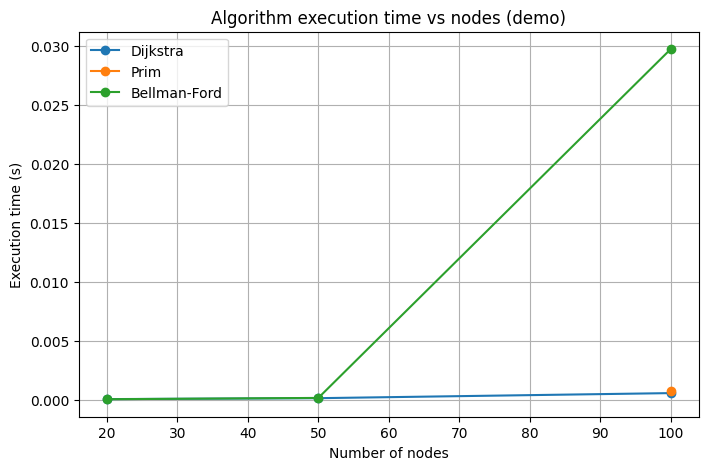

In [10]:
import random

def generate_random_graph_undirected(n_nodes, p_edge=0.2, weight_range=(1, 20)):
    nodes = [f"N{i}" for i in range(n_nodes)]
    graph = {n: [] for n in nodes}
    edges = []
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if random.random() < p_edge:
                w = random.randint(*weight_range)
                graph[nodes[i]].append((nodes[j], w))
                graph[nodes[j]].append((nodes[i], w))
                edges.append((nodes[i], nodes[j], w))
    return nodes, graph, edges

def generate_random_graph_directed(n_nodes, p_edge=0.2, weight_range=(-5, 20)):
    nodes = [f"N{i}" for i in range(n_nodes)]
    edges = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j and random.random() < p_edge:
                w = random.randint(*weight_range)
                edges.append((nodes[i], nodes[j], w))
    return nodes, edges

# Quick profiling on a few sizes
sizes = [20, 50, 100]  # keep smallish for Colab demo; increase for deeper study
results = []

for n in sizes:
    print(f"\n--- Profiling with n={n} nodes ---")
    # For Dijkstra and Prim (undirected positive weights)
    nodes, graph_u, edges_u = generate_random_graph_undirected(n, p_edge=0.08, weight_range=(1,50))
    src = nodes[0]

    # Dijkstra timing
    (dij_res, dij_time) = profile_time(dijkstra, graph_u, src)
    print(f"Dijkstra time: {dij_time:.4f}s")

    # Prim timing
    try:
        (prim_res, prim_time) = profile_time(prim_mst, graph_u)
        print(f"Prim time: {prim_time:.4f}s")
    except ValueError as e:
        prim_res, prim_time = None, None
        print("Prim: graph not connected, skipped.")

    # For Bellman-Ford (directed)
    nodes_d, edges_d = generate_random_graph_directed(n, p_edge=0.04, weight_range=(-2, 20))
    # ensure source in nodes
    src_d = nodes_d[0]
    (bf_res, bf_time) = profile_time(bellman_ford, nodes_d, edges_d, src_d)
    print(f"Bellman-Ford time: {bf_time:.4f}s")

    results.append({
        "n": n,
        "dijkstra_time": dij_time,
        "prim_time": prim_time,
        "bellman_time": bf_time
    })

# Plot times
plt.figure(figsize=(8,5))
ns = [r['n'] for r in results]
plt.plot(ns, [r['dijkstra_time'] for r in results], marker='o', label='Dijkstra')
plt.plot(ns, [r['prim_time'] if r['prim_time'] is not None else float('nan') for r in results], marker='o', label='Prim')
plt.plot(ns, [r['bellman_time'] for r in results], marker='o', label='Bellman-Ford')
plt.xlabel("Number of nodes")
plt.ylabel("Execution time (s)")
plt.title("Algorithm execution time vs nodes (demo)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Memory profiling example for Dijkstra
nodes, graph_u, edges_u = generate_random_graph_undirected(200, p_edge=0.04)
src = nodes[0]

# measure memory (peak delta)
(res, peak_mem) = profile_memory(dijkstra, graph_u, src)
print(f"Dijkstra run peak memory delta (approx): {peak_mem:.4f} MiB")


Dijkstra run peak memory delta (approx): 0.0000 MiB


In [12]:
reqs = ["networkx", "matplotlib", "memory-profiler"]
with open("requirements.txt","w") as f:
    f.write("\n".join(reqs))
print("requirements.txt saved.")


requirements.txt saved.
